In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

from state_inference.env import ObservationModel, TransitionModel
from state_inference.model import (
    Encoder, Decoder, StateVae, DEVICE, TransitionPredictor
    )
from state_inference.data import PomdpDataset
from state_inference.pytorch_utils import train_epochs


In [3]:
import sys

print(f"python {sys.version}")
print(f"torch {torch.__version__}")
print(f"device = {DEVICE}")

python 3.9.16 (main, Mar  8 2023, 04:29:24) 
[Clang 14.0.6 ]
torch 2.0.0
device = mps


### Generate the task

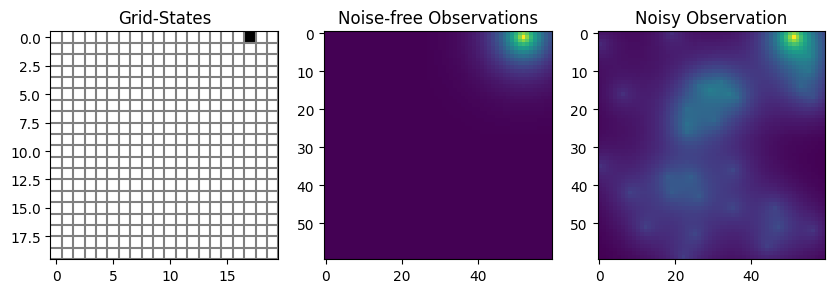

In [4]:
# Discritized states: a 20x20 grid of states, which we embed by spacing
# evenly in a nXn space
HEIGHT, WIDTH = 20, 20
MAP_HEIGHT = 60


gw_kwargs = dict(
    rbf_kernel_size=51, rbf_kernel_scale=0.2, location_noise_scale=1.0  # must be odd
)


observation_model = ObservationModel(HEIGHT, WIDTH, MAP_HEIGHT, **gw_kwargs)
transition_model = TransitionModel(HEIGHT, WIDTH)


# show an example location
s = 17
observation_model.display_state(s)

### Generate the training / test datasets

In [5]:
### Simulation Parameters
N_TRAINING_EXAMPLES = 10000
N_TEST_EXAMPLES = 2000
BATCH_SIZE = 64

# Create the dataloaders from the dataset
args = [transition_model, observation_model]
train_obs = PomdpDataset(*args, N_TRAINING_EXAMPLES, n_chains=10)
test_obs = PomdpDataset(*args, N_TEST_EXAMPLES)

train_loader = data.DataLoader(
    train_obs,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_loader = data.DataLoader(test_obs, batch_size=BATCH_SIZE)

### Define the model

In [6]:
### Model + Training Parameters
N_EPOCHS = 1  # should be 20
EMBEDDING_LAYERS = 5
EMBEDDING_DIM = len(observation_model.states) // 2
OBSERVATION_DIM = observation_model.map_height**2
LR = 3e-4
beta = 2.0
tau = 1.0
gamma = 0.95
dropout = 0.01

# create the model
z_dim = EMBEDDING_DIM * EMBEDDING_LAYERS
encoder_hidden = [OBSERVATION_DIM // 5, OBSERVATION_DIM // 10]
decoder_hidden = [OBSERVATION_DIM // 10, OBSERVATION_DIM // 5]
transition_hidden = [z_dim * 10, z_dim * 10]

encoder = Encoder(
    OBSERVATION_DIM,
    encoder_hidden,
    z_dim,
    dropout=dropout,
)
decoder = Decoder(
    z_dim,
    decoder_hidden,
    OBSERVATION_DIM,
    dropout=dropout,
)

vae_kwargs = dict(
    z_dim=EMBEDDING_DIM,
    z_layers=EMBEDDING_LAYERS,
    beta=beta, tau=tau, gamma=gamma
)

observation_model = StateVae(encoder, decoder, **vae_kwargs).to(DEVICE)

In [7]:
def preprocess_fn(batch_data):
    x, _ = batch_data
    return x


train_losses, test_losses = train_epochs(
    observation_model,
    train_loader,
    test_loader,
    dict(epochs=N_EPOCHS, lr=LR, clip_grad=True),
    preprocess=preprocess_fn,
)

check epoch
check train
Epoch 0, ELBO Loss (test) 6.2705


In [8]:
# encode the observations as a preprocessing step
def preprocess_fn(batch_data):
    observation_model.eval()
    x, y = batch_data
    with torch.no_grad():
        _, z_x = observation_model.encode(x.to(DEVICE))
        _, z_y = observation_model.encode(y.to(DEVICE))
    return z_x, z_y

transition_model = TransitionPredictor(
    transition_hidden, z_dim=EMBEDDING_DIM, z_layers=EMBEDDING_LAYERS
).to(DEVICE)

train_losses, test_losses = train_epochs(
    transition_model,
    train_loader,
    test_loader,
    dict(epochs=N_EPOCHS, lr=LR, clip_grad=True),
    preprocess=preprocess_fn,
)
# print(transition_model)

check epoch
check train
Epoch 0, ELBO Loss (test) 0.0019
